# Scenarios In Depth

Scenarios are the heart of a simulation. A scenario defines which simulation model to use, has a name and optionally points to a source model. 
It may override model constants and define execution strategies. 

## Understanding The Scenario Definition Format

Execution strategies change constants in different steps of the simulation. See the "strategy simulation" section for details.
You write scenarios in [JSON format](http://www.json.org). The default location to store scenarios is the ``scenarios`` subfolder of your current working directory. The path to the ``scenarios`` folder can be changed in the bptk config. 

Simulations are grouped using "scenario managers". A scenario manager has a name and encapsulates one simulation model and an arbitrary number of scenarios. Scenarios are used to modify the initial values of a model. The required model is defined in the scenario manager's config file.
One JSON file may contain more than one scenario manager. A simple example file with one scenario manager might look like this:

```
{  
    "smSimpleProjectManagement": {
        "source":"simulation_models/sd_simple_project.itmx",
        "model":"simulation_models/sd_simple_project",
        "base_constants": {
            "deadline": 100,
            "effortPerTask": 1,
            "initialOpenTasks": 80,
            "initialStaff": 1
        },
        "base_points": {
            "productivity" : [
            [0,0.4],
            [0.25,0.444],
            [0.5,0.506],
            [0.75,0.594],
            [1,1],
            [1.25,1.119],
            [1.5,1.1625],
            [1.75,1.2125],
            [2,1.2375],
            [2.25,1.245],
            [2.5,1.25]
            ]
        },
        "scenarios": {
            "base": {
            },
            "scenario100": {
                "constants": {
                    "initialOpenTasks": 100
                }
            },
            "scenario80": {
                "constants": {
                }
            },
            "scenario120": {
                "constants": {
                    "initialOpenTasks": 120
                }
            }
        }
    }
}
```
A scenario manager requires a name.
If the same name for a scenario manager is used in multiple files, this will be detected and the configs will be merged into one scenario manager. 
The scenario manager stores the model (source file and python file) as well as all scenarios that belong to it.
The ``model`` property contains the relative path to the (python) simulation model. If using a relative path, keep in mind that ``BPTK_Py`` looks for the file from your current working directory, i.e. the path of your script or jupyter notebook. 
The ``source`` property contains the relative path to the original model created in a 3rd party application. The framework provides automatic conversion from .itmx/.stmx (Stella Architect) files. When working with a supported 3rd party application, it is recommended to set the ``source`` property. When a value for ``source`` is provided, a file monitor will run in the background and check for changes in the source model. When changes are found the framework automatically updates the python model.

The ``base_constants`` property defines the initial state for the model, regardless of the state in the model source file.
``base_constants`` can stretch over multiple files. If that is the case, ``bptk_py`` attempts to merge them and data loss may occur due to duplicate values for the same constants.
The ``base_points`` property is used to define an initial state for graphical functions.

Scenarios are defined in the ``scenario`` property. 
Each scenario requires a unique name and a ``constants`` property. The ``constants`` property is used to override base constants (which were set in the ``base_constants`` property). In the example above ``scenario100`` overrides ``initialOpenTasks`` with the value ``100``, so that, when this scenario is run, the initial value for ``initialOpenTasks`` in the model is set to ``100``. ``scenario80`` does not override this value, therefore the ``initialOpenTasks`` value from the ``base_constants`` field is used when running this scenario.

Values may either be defined using numerical expressions such as ``0.5`` or strings such as ``"4/10"`` which will be converted to ``0.4`` by the framework.

Spreading scenarios across multiple files for one scenario manager can improve readability in situations with a high number of scenarios.

## Creating Scenarios During Runtime

It is possible to add scenarios during runtime. Here is example code that may be used as a template to generate scenarios during runtime. 

First, the details for the scenario manager are defined. After that, the name for the scenario is set up, then the strategy and the constants.


In [1]:
import BPTK_Py
bptk = BPTK_Py.bptk()

scenario_manager={
    "smSimpleProject_temp":
    {
        "source": "simulation_models/sd_simple_project.itmx",
        "model": "simulation_models/sd_simple_project"
    }
}
scenario_name = "scenario160"


constants = {
            "deadline" : 160,
            "effortPerTask" : 0.1
        }


scenario_dictionary ={
                 scenario_name:{
                     "constants" : constants
                 } 
             } 
            

bptk.register_scenario_manager(scenario_manager)
bptk.register_scenarios(scenario_manager="smSimpleProject_temp",scenarios=scenario_dictionary)



In [2]:
#| echo: false
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [3]:
bptk.list_scenarios(scenario_managers=["smSimpleProject_temp"])


*** smSimpleProject_temp ***
	 scenario160


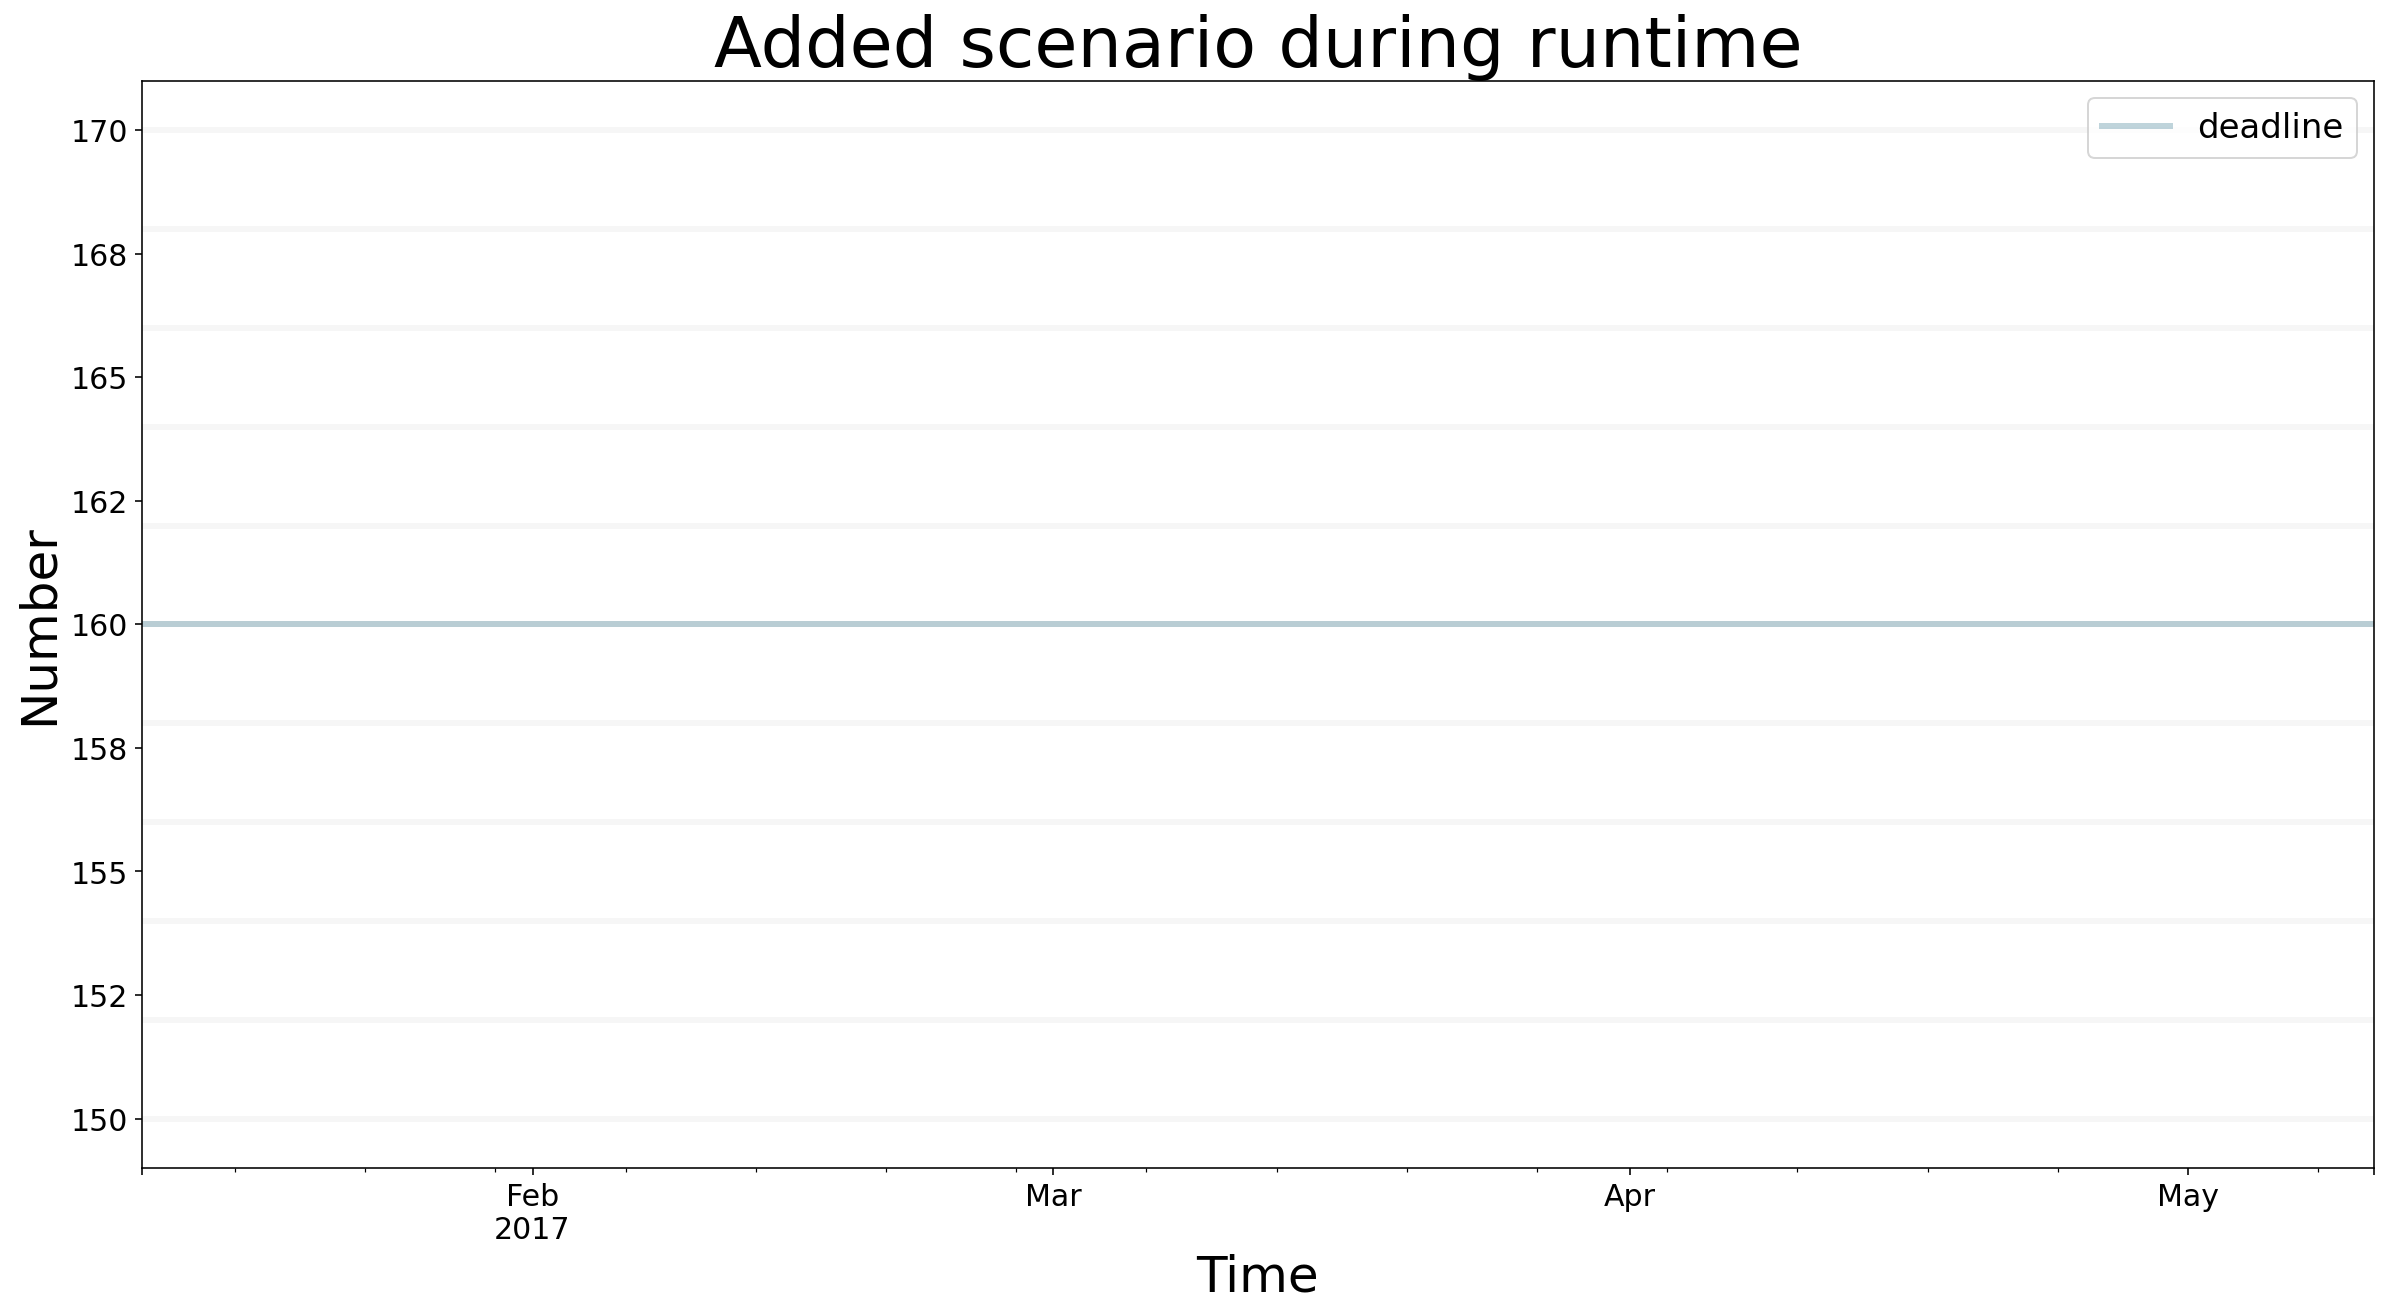

In [4]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProject_temp"],
    scenarios=["scenario160"],
    kind="line",
    equations=["deadline"],
    stacked=False,
    freq="D", 
    start_date="1/11/2017",
    title="Added scenario during runtime",
    x_label="Time",
    y_label="Number",
)

You can also register a scenario manger along with some scenarios directly:

In [5]:
scenario_manager={
    "smSimpleProject_another_temp":
    {
        "source": "simulation_models/sd_simple_project.itmx",
        "model": "simulation_models/sd_simple_project",
        "scenarios":{
            "scenario160":{
                "constants":{
                    "deadline" : 160,
                    "effortPerTask" : 0.1
                }
            }
        }
    }
}


bptk.register_scenario_manager(scenario_manager)

In [6]:
bptk.list_scenarios(scenario_managers=["smSimpleProject_temp","smSimpleProject_another_temp"])


*** smSimpleProject_temp ***
	 scenario160

*** smSimpleProject_another_temp ***
	 scenario160


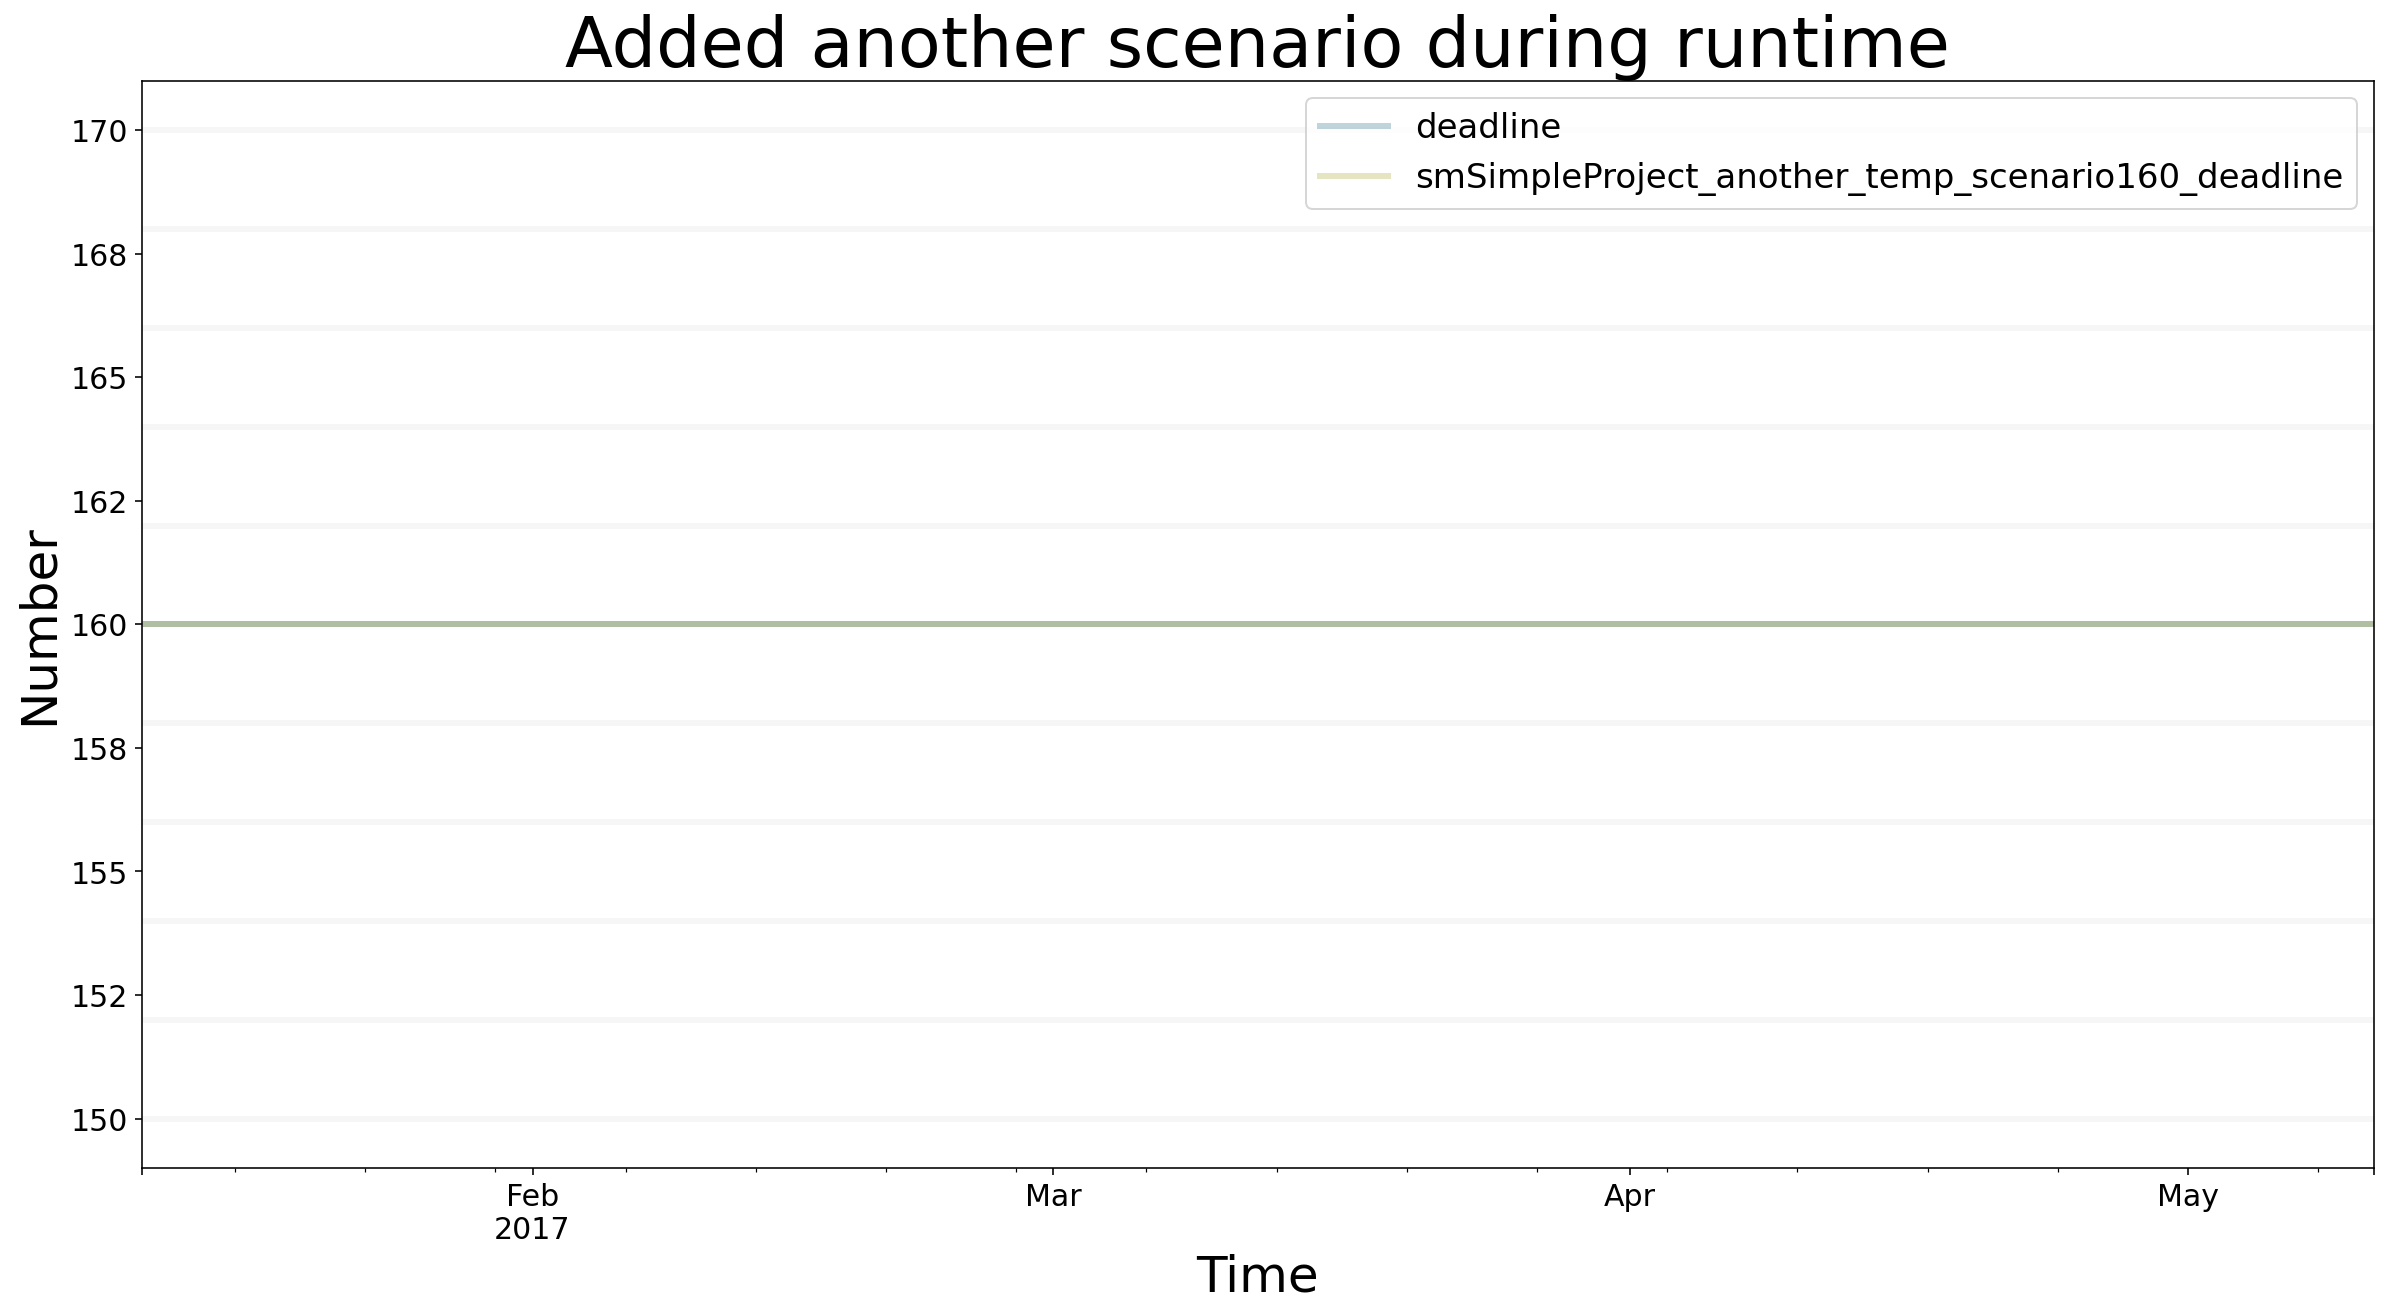

In [7]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProject_another_temp","smSimpleProject_temp"],
    scenarios=["scenario160"],
    kind="line",
    equations=["deadline"],
    stacked=False,
    freq="D", 
    start_date="1/11/2017",
    title="Added another scenario during runtime",
    x_label="Time",
    y_label="Number",
)

## Resetting Scenarios
After simulating for a while, modifying strategies, constants, and generating beautiful plots, it may be time to reset the simulation. For this purpose, three methods are available:
* ``reset_scenario(scenario_manager, scenario)``: Delete a specific scenario from memory and reload it from file. Requires the scenario manager's name and the scenario name.
* ``reset_all_scenarios()``: Reset all scenarios and reload from file
* ``reset_scenario_cache(scenario_manager, scenario="")``: To optimize the runtime, scenarios cache the results of previous timesteps and previous runs. In some rare cases, this cache may not be flushed upon scenario modification. Hence, this method resets the simulation model's cache.

Example usages below:

In [8]:
bptk.reset_scenario(scenario_manager="smSimpleProjectManagement",scenario="scenario80")

bptk.reset_all_scenarios()

bptk.reset_scenario_cache("smSimpleProjectManagement","scenario80")
